## Prepare imports

In [52]:
from omegaconf import OmegaConf
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch_geometric.data import Batch,Data

from models.vae import VanillaVAE
from models.vae import BaseModel as BaseVAE

from models.encoder import BaseModel as EctEncoder

from metrics.metrics import get_mse_metrics
from metrics.accuracies import compute_mse_accuracies
from metrics.loss import compute_mse_loss_fn



from datasets.mnist import DataModule, DataModuleConfig
from layers.ect import EctLayer, EctConfig

from layers.directions import generate_directions

DEVICE = "cuda:0"
ECT_PLOT_CONFIG = {"cmap":"bone","vmin":-0.5,"vmax":1.5}
PC_PLOT_CONFIG = {"s":10,"c":'.5'}
encoder_config = OmegaConf.load("./configs/config_encoder_mnist.yaml")
vae_config = OmegaConf.load("./configs/config_vae_mnist.yaml")

## Load Models and Data

In [53]:
layer = EctLayer(
    EctConfig(
        num_thetas=encoder_config.layer.ect_size,
        bump_steps=encoder_config.layer.ect_size,
        normalized=True,
        device=DEVICE,
    ),
    v=generate_directions(encoder_config.layer.ect_size,encoder_config.layer.dim, DEVICE),
)

dm = DataModule(DataModuleConfig(root="./data/mnistpointcloud"))


vae_model = VanillaVAE(in_channels=vae_config.model.in_channels, latent_dim=vae_config.model.latent_dim,img_size=vae_config.layer.ect_size)

# Load the VAE model

metrics = get_mse_metrics()

vae_litmodel = BaseVAE.load_from_checkpoint(
    f"./trained_models/{vae_config.model.save_name}",
    model=vae_model,
    training_accuracy=metrics[0],
    test_accuracy=metrics[1],
    validation_accuracy=metrics[2],
    accuracies_fn=compute_mse_accuracies,
    loss_fn=compute_mse_loss_fn,
    learning_rate=0.01,
    layer=layer,
).to(DEVICE)


# Load the encoder 

ect_encoder_litmodel = EctEncoder.load_from_checkpoint(
    f"./trained_models/{encoder_config.model.save_name}",
    layer=layer,
    ect_size=encoder_config.layer.ect_size,
    hidden_size=encoder_config.model.hidden_size,
    num_pts=encoder_config.model.num_pts,
    num_dims=encoder_config.model.num_dims,
    learning_rate=encoder_config.model.learning_rate,
).to(DEVICE)


## Generate an ECT and use VAE as autoencoder to recreate the ECT

In [54]:
data_list = []
for idx in range(10):
    data_list.append(dm.test_ds[dm.test_ds.y==idx][1])

batch = Batch.from_data_list(data_list).to(DEVICE)

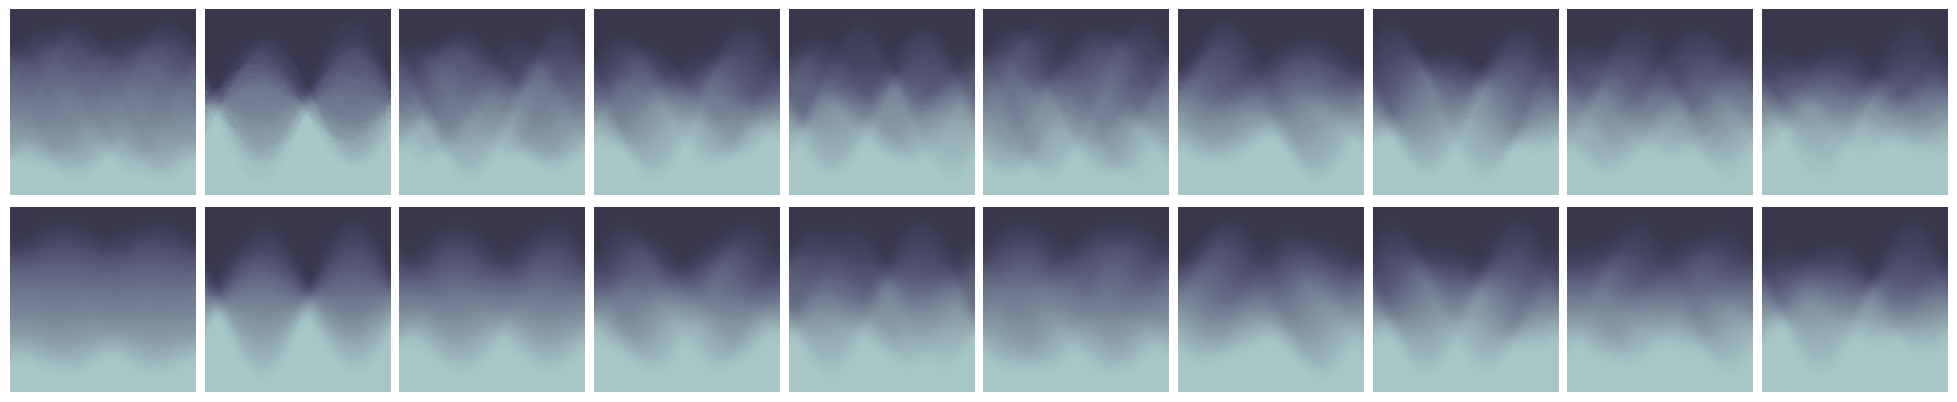

In [58]:

ect = layer(batch,batch.batch).unsqueeze(1)


with torch.no_grad():
    decoded, theinput, z_mean, z_log_var = vae_litmodel.forward(ect)

# Undo the VAE transform
decoded = (decoded + 1 ) / 2

n_images = 10

fig, axes = plt.subplots(
    nrows=2, ncols=n_images, sharex=True, sharey=True, figsize=(25,5)
)
fig.subplots_adjust(wspace=0.05,hspace=0.05)

for orig_img, recon_img,ax in zip(ect,decoded,axes.T):
    ax[0].imshow(orig_img.cpu().detach().squeeze().numpy(),**ECT_PLOT_CONFIG)
    ax[0].axis("off")
    ax[1].imshow(recon_img.cpu().detach().squeeze().numpy(),**ECT_PLOT_CONFIG)
    ax[1].axis("off")



def rotate(p, origin=(0, 0), degrees=0):
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)


plt.savefig("./figures/img/mnist/reconstructed_ect_vae.png",transparent=True)   

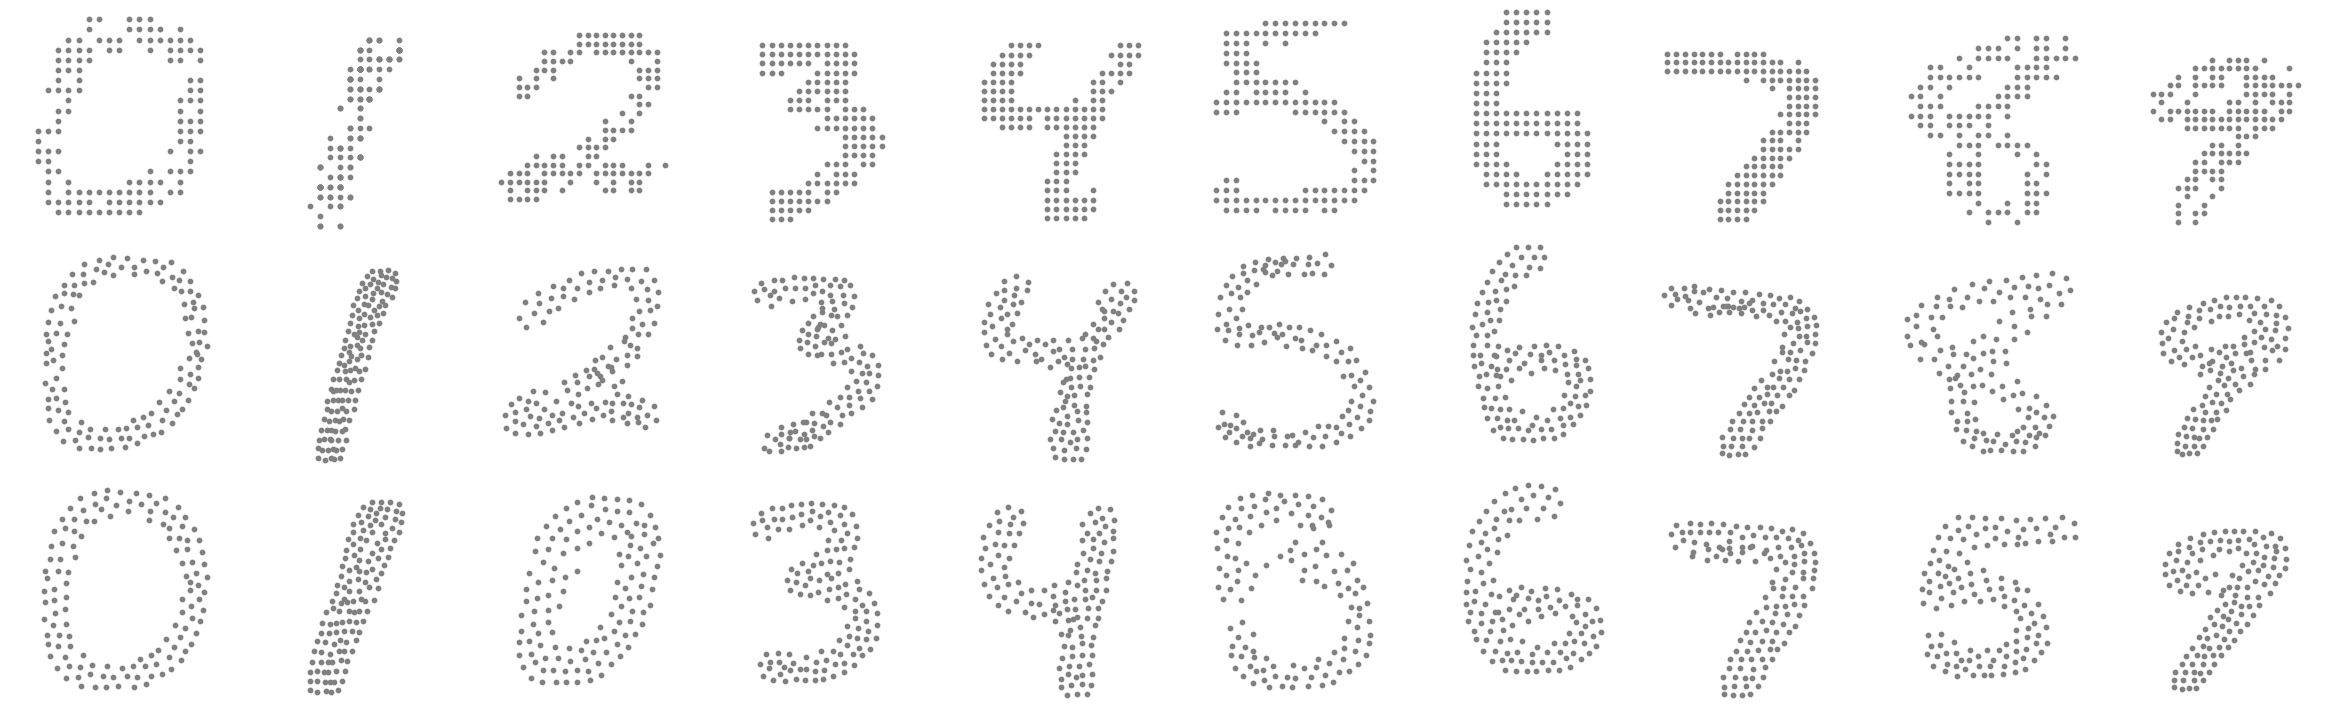

In [59]:


with torch.no_grad():
    recon_vae_batch = ect_encoder_litmodel.model.forward(decoded)
    recon_batch = ect_encoder_litmodel.model.forward(ect)


n_images = 10

fig, axes = plt.subplots(
    nrows=3, ncols=n_images, sharex=True, sharey=True, figsize=(30,9)
)
fig.subplots_adjust(wspace=0.05,hspace=0.05)

for orig_pts, recon_pts, recon_vae_pts,ax in zip(batch.x.view(-1,128,2),recon_batch,recon_vae_batch,axes.T):
    # print(recon_pts_x.shape)
    recon_pts = recon_pts.view(-1,2).cpu().detach().squeeze().numpy()
    orig_pts = orig_pts.view(-1,2).cpu().detach().squeeze().numpy()
    recon_vae_pts = recon_vae_pts.view(-1,2).cpu().detach().squeeze().numpy()
    orig_pts = rotate(orig_pts, degrees=-90)
    recon_pts = rotate(recon_pts, degrees=-90)
    recon_vae_pts = rotate(recon_vae_pts, degrees=-90)
    ax[0].scatter(orig_pts[:,0],orig_pts[:,1],**PC_PLOT_CONFIG)
    ax[0].set_xlim([-1,1])
    ax[0].set_ylim([-1,1])
    ax[0].set_aspect(1)
    ax[0].axis("off")
    
    ax[1].scatter(recon_pts[:,0],recon_pts[:,1],**PC_PLOT_CONFIG)
    ax[1].set_xlim([-1,1])
    ax[1].set_ylim([-1,1])
    ax[1].set_aspect(1)
    ax[1].axis("off")

    ax[2].scatter(recon_vae_pts[:,0],recon_vae_pts[:,1],**PC_PLOT_CONFIG)
    ax[2].set_xlim([-1,1])
    ax[2].set_ylim([-1,1])
    ax[2].set_aspect(1)
    ax[2].axis("off")



plt.savefig("./figures/img/mnist/reconstructed_pointcloud_vae.png",transparent=True) 

## Sample from VAE and reconstruct points 

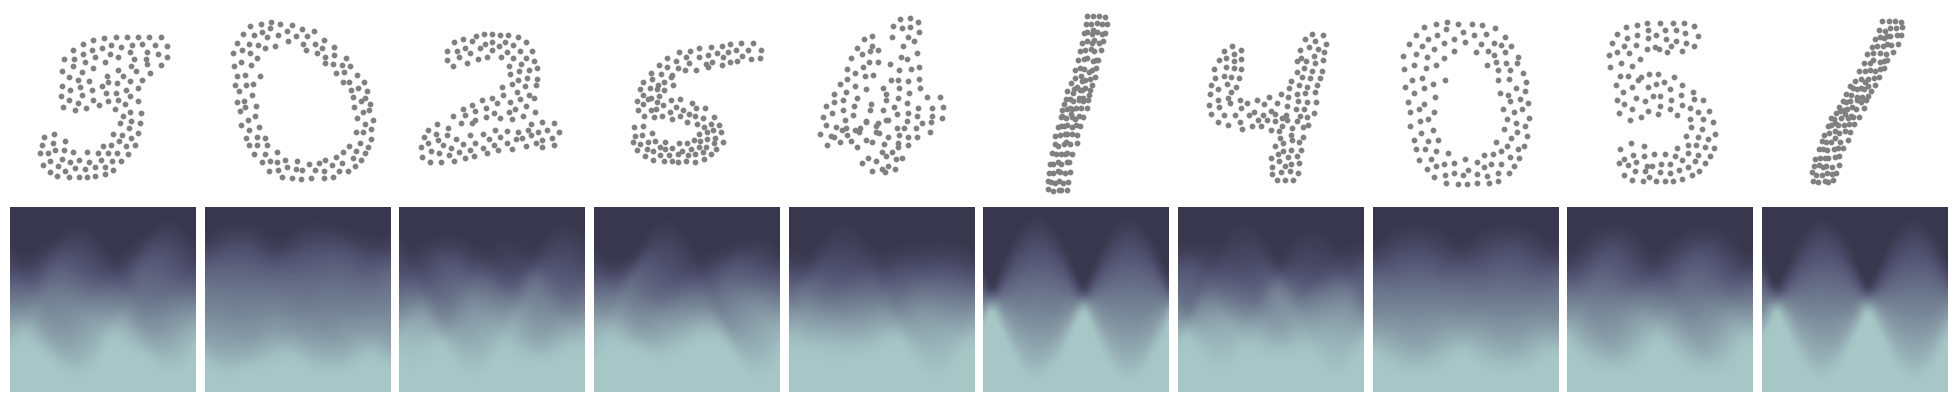

In [61]:
samples = vae_litmodel.model.sample(64, "cuda:0")
samples = (samples + 1) / 2
recon_samples = ect_encoder_litmodel.model.forward(samples)


n_images = 10

fig, axes = plt.subplots(
    nrows=2, ncols=n_images, figsize=(25,5)
)
fig.subplots_adjust(wspace=0.05,hspace=0.05)


for samples_pts,sample,ax in zip(recon_samples,samples,axes.T):
    samples_pts = samples_pts.view(-1,2).cpu().detach().squeeze().numpy()
    samples_pts = rotate(samples_pts, degrees=-90)
    ax[0].scatter(samples_pts[:,0],samples_pts[:,1],**PC_PLOT_CONFIG)
    ax[0].set_xlim([-1,1])
    ax[0].set_ylim([-1,1])
    ax[0].set_aspect(1)
    ax[0].axis("off")
    ax[1].imshow(sample.squeeze().cpu().detach().numpy(),**ECT_PLOT_CONFIG)
    ax[1].axis("off")



plt.savefig("./figures/img/mnist/generated_samples_vae.png",transparent=True) 